# 思路
1. 需要随机初始点，但是test_env中是利用上一次的初始状态
2. 直接更改reward规则来约束exposure
3. 更改卖空机制以及金钱下线
4. 可能需要downround（在计算购买股票的钱的时候，防止upround直接爆balance）


## 结构
[PPO.train()](https://github.com/DLR-RM/stable-baselines3/blob/75b6f3b3b0f207456d9dcac2c6e86e8e2a22115f/stable_baselines3/ppo/ppo.py#L181)

[OnPolicyAlgorithm.rollout_buffer](https://github.com/DLR-RM/stable-baselines3/blob/75b6f3b3b0f207456d9dcac2c6e86e8e2a22115f/stable_baselines3/common/on_policy_algorithm.py#L112)

[RolloutBuffer]()

无效，太深了，不能改

## kalman

[不错](https://www.cnblogs.com/PythonLearner/p/12925724.html)

## RL

自己新开一个env，里面的 action space只是买入-k~k的标的1，并用卡拉曼计算hedge ratio来相反操作另一个


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/HYF/Graduation_Fin/FinRL
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install tushare
# !pip install -r requirements1.txt

/content/drive/MyDrive/HYF/Graduation_Fin/FinRL
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-l_gbd78p
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-l_gbd78p
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-sqtywpfp/pyfolio_9e9e63f5e2144c119e567c57cc2c037f
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-sqtywpfp/pyfolio_9e9e63f5e2144c119e567c57cc2c037f
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-sqtywpfp/elegantrl_d0cd37ee54bc4f81b61f78b8698d394c
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-sqtywpfp/elegantrl_d0cd37ee54bc4f81b61f78b8698d394c


#git

In [38]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   FinRL_StockTrading_NeurIPS_2018.ipynb
	modified:   finrl/finrl_meta/env_stock_trading/env_test.py
	modified:   finrl/finrl_meta/preprocessor/preprocessors.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	finrl/finrl_meta/env_stock_trading/env_pairs_trading.py
	requirements1.txt

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
# !git add finrl/finrl_meta/env_stock_trading/env_test.py
# !git add finrl/finrl_meta/env_stock_trading/env_test.py

!git add -u

In [ ]:
!git config --global user.email "939778128@qq.com"
!git config --global user.name "EvanHong99"
!git commit -m "我需要requirements"

[master 086a456] 我需要requirements
 3 files changed, 37 insertions(+), 4 deletions(-)
 rewrite FinRL_StockTrading_NeurIPS_2018.ipynb (94%)


In [ ]:
!git pull

Already up to date.


In [ ]:
!git push

Counting objects: 8, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 21.58 KiB | 1.96 MiB/s, done.
Total 8 (delta 7), reused 0 (delta 0)
remote: Resolving deltas: 100% (7/7), completed with 7 local objects.
To https://github.com/EvanHong99/FinRL.git
   586d3ad..086a456  master -> master


<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
%cd /content/drive/MyDrive/HYF/Graduation_Fin/FinRL
root='/content/drive/MyDrive/HYF/Graduation_Fin/FinRL'
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists(root+"/" + config.DATA_SAVE_DIR):
    os.makedirs(root+"/" + config.DATA_SAVE_DIR)
if not os.path.exists(root+"/" + config.TRAINED_MODEL_DIR):
    os.makedirs(root+"/" + config.TRAINED_MODEL_DIR)
if not os.path.exists(root+"/" + config.TENSORBOARD_LOG_DIR):
    os.makedirs(root+"/" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists(root+"/" + config.RESULTS_DIR):
    os.makedirs(root+"/" + config.RESULTS_DIR)

/content/drive/MyDrive/HYF/Graduation_Fin/FinRL



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
# from finrl.finrl_meta.preprocessor.processor_joinquant import JoinQuantEngineer
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv

from finrl.finrl_meta.env_stock_trading.env_test import StockTradingEnv

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools
import jqdatasdk
jqdatasdk.auth('15857500957','Qazwsxedcrfv0957')

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


auth success 


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.TRAIN_START_DATE

'2014-01-01'

In [5]:
# from config.py end_date is a string
config.TEST_END_DATE

'2021-10-01'

In [6]:
df = YahooDownloader(start_date = '2019-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
df.shape

(21367, 8)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2019-01-02,38.722500,39.712502,38.557499,38.277519,148158800,AAPL,2
1,2019-01-02,192.520004,193.199997,188.949997,174.294495,3009100,AMGN,2
2,2019-01-02,93.910004,96.269997,93.769997,91.087929,4175400,AXP,2
3,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200,BA,2
4,2019-01-02,124.029999,127.879997,123.000000,116.297012,4783200,CAT,2


In [10]:
ndf = TushareDownloader(start_date = '2019-01-01',
                     end_date = '2021-10-31',
                     ticker_list = ['600036.SH','002142.SZ']).fetch_data()
                    #  ticker_list = ['600036.SH','002142.SZ','601398.SH', '600000.SH','601818.SH','600050.SH','300750.SZ']).fetch_data()
ndf

  0%|          | 0/2 [00:00<?, ?it/s]

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


 50%|█████     | 1/2 [00:00<00:00,  1.13it/s]

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

Shape of DataFrame:  (1003, 9)
            date   open   high  close    low     volume  turnover     tic  day
0     2019-10-09  26.28  27.54  26.94  25.95  377299.44      0.67  002142    2
1     2019-10-10  26.83  27.22  26.95  26.47  223220.73      0.40  002142    3
2     2019-10-11  26.96  27.61  27.53  26.70  219037.48      0.39  002142    4
3     2019-10-14  27.70  28.44  27.40  27.10  321621.81      0.57  002142    0
4     2019-10-15  27.35  27.35  27.12  26.58  269618.19      0.48  002142    1
...          ...    ...    ...    ...    ...        ...       ...     ...  ...
998   2021-10-25  53.83  54.93  54.59  53.10  623341.25      0.30  600036    0
999   2021-10-26  54.59  56.23  55.30  54.30  715423.69      0.35  600036    1
1000  2021-10-27  55.20  55.20  54.52  53.83  420394.41      0.20  600036    2
1001  2021-10-28  54.30  55.00  54.22  53.85  346232.28      0.17  600036    3
1002  2021-10-29  54.22  54.75  53.97  53.70  405439.44      0.20  600036    4

[1003 rows x 9 colum


/content/drive/MyDrive/HYF/Graduation_Fin/FinRL/finrl/finrl_meta/preprocessor/tusharedownloader.py:65: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_df = data_df.drop(["price_change","p_change","ma5","ma10","ma20","v_ma5","v_ma10","v_ma20"], 1)


,date,open,high,close,low,volume,turnover,tic,day
0,2019-10-09,26.28,27.54,26.94,25.95,377299.44,0.67,002142,2
1,2019-10-09,34.52,35.67,35.18,34.50,821613.75,0.40,600036,2
2,2019-10-10,26.83,27.22,26.95,26.47,223220.73,0.40,002142,3
3,2019-10-10,35.21,35.38,35.11,35.02,378700.53,0.18,600036,3
4,2019-10-11,26.96,27.61,27.53,26.70,219037.48,0.39,002142,4
...,...,...,...,...,...,...,...,...,...
998,2021-10-27,55.20,55.20,54.52,53.83,420394.41,0.20,600036,2
999,2021-10-28,38.18,38.70,37.88,37.36,220415.56,0.37,002142,3
1000,2021-10-28,54.30,55.00,54.22,53.85,346232.28,0.17,600036,3
1001,2021-10-29,39.00,39.25,38.20,37.83,294159.97,0.50,002142,4


In [11]:
# ticks=[('601398.XSHG', '600000.XSHG'),
#  ('601398.XSHG', '600050.XSHG'),
#  ('601398.XSHG', '601818.XSHG'),
#  ('600000.XSHG', '600050.XSHG')]
# mydf=jqdatasdk.get_price(ticks[0],'2021-01-01','2021-12-31').drop('money',axis=1)
# mydf=mydf.rename(columns={'time':'date','code':'tic',})
# mydf=mydf.sort_values(['date','tic'],ignore_index=True)
# mydf['day']=pd.DataFrame(data=np.zeros(len(mydf),dtype=np.int8))

In [12]:
# mydf

In [13]:
# t=mydf
# d=np.array(sorted(set(t['date'].dt.date)))
# t['day']=t['date'].apply(lambda x:np.where(d==x)[0][0])
# mydf=t
# mydf

In [14]:
# mydf=mydf.sort_values(['date','tic'],ignore_index=True)
# mydf

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: **MACD and RSI.**
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [96]:
# merged_closes = df.pivot_table(index="date", columns="tic", values="close")


In [15]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True,
                    use_turbulence=False,
                    user_defined_feature = False)

# processed = fe.preprocess_data(df)
processed = fe.preprocess_data(ndf)
processed

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (519, 8)
Successfully added vix


,date,open,high,close,low,volume,turnover,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2019-10-09,26.28,27.54,26.94,25.95,377299.44,0.67,002142,2,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,26.940000,26.940000,18.639999
1,2019-10-09,34.52,35.67,35.18,34.50,821613.75,0.40,600036,2,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,35.180000,35.180000,18.639999
2,2019-10-10,26.83,27.22,26.95,26.47,223220.73,0.40,002142,3,0.000224,26.959142,26.930858,100.000000,66.666667,100.000000,26.945000,26.945000,17.570000
3,2019-10-10,35.21,35.38,35.11,35.02,378700.53,0.18,600036,3,-0.001571,35.243995,35.046005,0.000000,66.666667,100.000000,35.145000,35.145000,17.570000
4,2019-10-11,26.96,27.61,27.53,26.70,219037.48,0.39,002142,4,0.018272,27.815574,26.464426,100.000000,100.000000,100.000000,27.140000,27.140000,15.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,2021-10-26,54.59,56.23,55.30,54.30,715423.69,0.35,600036,1,0.905397,55.907193,48.025807,56.819333,161.034620,27.304537,52.044667,50.821833,15.980000
967,2021-10-27,38.58,38.87,38.45,37.97,149993.34,0.25,002142,2,0.935435,40.209902,33.377098,55.536024,101.200771,23.170640,36.175000,35.070500,16.980000
968,2021-10-27,55.20,55.20,54.52,53.83,420394.41,0.20,600036,2,0.933634,56.127249,48.316751,55.130135,114.567688,21.459275,52.155333,50.935500,16.980000
969,2021-10-28,38.18,38.70,37.88,37.36,220415.56,0.37,002142,3,0.879953,40.171473,33.801527,53.985588,75.318661,12.762654,36.267667,35.160167,16.530001


In [16]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [17]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2019-10-09,002142,26.28,27.54,26.94,25.95,377299.44,0.67,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,26.940000,26.940000,18.639999
1,2019-10-09,600036,34.52,35.67,35.18,34.50,821613.75,0.40,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,35.180000,35.180000,18.639999
2,2019-10-10,002142,26.83,27.22,26.95,26.47,223220.73,0.40,3.0,0.000224,26.959142,26.930858,100.000000,66.666667,100.000000,26.945000,26.945000,17.570000
3,2019-10-10,600036,35.21,35.38,35.11,35.02,378700.53,0.18,3.0,-0.001571,35.243995,35.046005,0.000000,66.666667,100.000000,35.145000,35.145000,17.570000
4,2019-10-11,002142,26.96,27.61,27.53,26.70,219037.48,0.39,4.0,0.018272,27.815574,26.464426,100.000000,100.000000,100.000000,27.140000,27.140000,15.580000
5,2019-10-11,600036,35.30,36.37,36.29,35.30,1043873.12,0.51,4.0,0.034591,36.850651,34.202683,94.576543,100.000000,100.000000,35.526667,35.526667,15.580000
6,2019-10-14,002142,27.70,28.44,27.40,27.10,321621.81,0.57,0.0,0.021339,27.814809,26.595191,81.428866,106.199461,100.000000,27.205000,27.205000,14.570000
7,2019-10-14,600036,36.60,37.44,36.83,36.60,874334.44,0.42,0.0,0.069686,37.545810,34.159190,96.253826,115.349226,100.000000,35.852500,35.852500,14.570000
8,2019-10-15,002142,27.35,27.35,27.12,26.58,269618.19,0.48,1.0,0.011414,27.721554,26.654446,57.596295,-27.227723,36.498335,27.188000,27.188000,13.540000
9,2019-10-15,600036,37.22,37.22,36.64,36.47,458104.97,0.22,1.0,0.079729,37.636837,34.383163,86.515039,74.666153,86.982729,36.010000,36.010000,13.540000


In [18]:
processed_full.to_csv('./datasets/train/processed_full.csv')

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [19]:
root='/content/drive/MyDrive/HYF/Graduation_Fin/FinRL'
%cd /content/drive/MyDrive/HYF/Graduation_Fin/FinRL
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists(root+"/" + config.DATA_SAVE_DIR):
    os.makedirs(root+"/" + config.DATA_SAVE_DIR)
if not os.path.exists(root+"/" + config.TRAINED_MODEL_DIR):
    os.makedirs(root+"/" + config.TRAINED_MODEL_DIR)
if not os.path.exists(root+"/" + config.TENSORBOARD_LOG_DIR):
    os.makedirs(root+"/" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists(root+"/" + config.RESULTS_DIR):
    os.makedirs(root+"/" + config.RESULTS_DIR)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
# from finrl.finrl_meta.preprocessor.processor_joinquant import JoinQuantEngineer
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_test import StockTradingEnv

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools
# import jqdatasdk
# jqdatasdk.auth('15857500957','Qazwsxedcrfv0957')

/content/drive/MyDrive/HYF/Graduation_Fin/FinRL


In [20]:
processed_full=pd.read_csv('./datasets/train/processed_full.csv',index_col=0,header=0,dtype={"tic":str})
# 只选择两个股票
processed_full=processed_full[np.logical_or(processed_full['tic']=='600036',processed_full['tic']=='002142')]
processed_full

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2019-10-09,002142,26.28,27.54,26.94,25.95,377299.44,0.67,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,26.940000,26.940000,18.639999
1,2019-10-09,600036,34.52,35.67,35.18,34.50,821613.75,0.40,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,35.180000,35.180000,18.639999
2,2019-10-10,002142,26.83,27.22,26.95,26.47,223220.73,0.40,3.0,0.000224,26.959142,26.930858,100.000000,66.666667,100.000000,26.945000,26.945000,17.570000
3,2019-10-10,600036,35.21,35.38,35.11,35.02,378700.53,0.18,3.0,-0.001571,35.243995,35.046005,0.000000,66.666667,100.000000,35.145000,35.145000,17.570000
4,2019-10-11,002142,26.96,27.61,27.53,26.70,219037.48,0.39,4.0,0.018272,27.815574,26.464426,100.000000,100.000000,100.000000,27.140000,27.140000,15.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,2021-10-26,600036,54.59,56.23,55.30,54.30,715423.69,0.35,1.0,0.905397,55.907193,48.025807,56.819333,161.034620,27.304537,52.044667,50.821833,15.980000
1498,2021-10-27,002142,38.58,38.87,38.45,37.97,149993.34,0.25,2.0,0.935435,40.209902,33.377098,55.536024,101.200771,23.170640,36.175000,35.070500,16.980000
1499,2021-10-27,600036,55.20,55.20,54.52,53.83,420394.41,0.20,2.0,0.933634,56.127249,48.316751,55.130135,114.567688,21.459275,52.155333,50.935500,16.980000
1500,2021-10-28,002142,38.18,38.70,37.88,37.36,220415.56,0.37,3.0,0.879953,40.171473,33.801527,53.985588,75.318661,12.762654,36.267667,35.160167,16.530001


In [21]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

344
628


In [22]:
train

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2019-10-09,002142,26.28,27.54,26.94,25.95,377299.44,0.67,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,26.940000,26.940000,18.639999
0,2019-10-09,600036,34.52,35.67,35.18,34.50,821613.75,0.40,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,35.180000,35.180000,18.639999
1,2019-10-10,002142,26.83,27.22,26.95,26.47,223220.73,0.40,3.0,0.000224,26.959142,26.930858,100.000000,66.666667,100.000000,26.945000,26.945000,17.570000
1,2019-10-10,600036,35.21,35.38,35.11,35.02,378700.53,0.18,3.0,-0.001571,35.243995,35.046005,0.000000,66.666667,100.000000,35.145000,35.145000,17.570000
2,2019-10-11,002142,26.96,27.61,27.53,26.70,219037.48,0.39,4.0,0.018272,27.815574,26.464426,100.000000,100.000000,100.000000,27.140000,27.140000,15.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2020-06-26,600036,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
170,2020-06-29,002142,26.22,26.52,26.39,25.85,307973.41,0.55,0.0,0.083559,27.726467,25.004533,53.675052,25.790950,16.527066,26.016000,25.046333,31.780001
170,2020-06-29,600036,34.17,34.30,33.64,33.49,567297.50,0.28,0.0,-0.147290,35.943614,32.941386,47.846759,-53.038389,0.688877,34.266000,33.729833,31.780001
171,2020-06-30,002142,26.48,26.70,26.27,26.16,282245.44,0.50,1.0,0.097145,27.706873,24.992127,53.036881,34.736262,19.670510,26.065000,25.099833,30.430000


In [23]:
trade.head()

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2020-07-01,002142,26.27,27.28,27.19,26.21,418918.59,0.75,2.0,0.180073,27.775980,24.973020,57.083722,85.002786,28.893817,26.131000,25.173000,28.620001
0,2020-07-01,600036,33.79,34.80,34.79,33.61,799096.44,0.39,2.0,-0.077263,35.944940,32.927060,52.960133,10.803952,13.406182,34.294667,33.789500,28.620001
1,2020-07-02,002142,27.15,28.05,27.89,26.75,577619.00,1.03,3.0,0.298832,27.915443,24.896557,59.809650,143.134805,38.856738,26.211000,25.258667,27.680000
1,2020-07-02,600036,34.65,35.47,35.30,34.30,1245178.00,0.60,3.0,0.026686,35.984104,32.913896,54.989425,73.899649,22.639615,34.329000,33.842333,27.680000
2,2020-07-06,002142,28.71,31.13,31.13,28.71,765799.62,1.36,0.0,0.737990,29.311641,23.974359,69.397261,308.013870,62.475503,26.485333,25.488333,27.940001


In [24]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [25]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 2, State Space: 21


In [26]:
from finrl.finrl_meta.env_stock_trading.env_test import StockTradingEnv
env_kwargs = { 
        "hmax": 100, 
        "initial_amount": 1e5, # 十万空余资金
        "num_stock_shares": [0] * stock_dimension, # 每个股票十手
        "buy_cost_pct": [0.000675] * stock_dimension, 
        "sell_cost_pct": [0.001] * stock_dimension, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.INDICATORS, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4,
        # "model_name":"pair_trading",
        # "mode":"test",
        # "":,
        
        
         }
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [27]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 3: PPO

In [28]:
agent = DRLAgent(env = env_train)

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [29]:
trained_ppo = agent.train_model(model=model_ppo, 
                    tb_log_name='ppo',
                    total_timesteps=20000)

going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short


/content/drive/MyDrive/HYF/Graduation_Fin/FinRL/finrl/finrl_meta/env_stock_trading/env_test.py:200: RuntimeWarning: divide by zero encountered in double_scalars
  available_amount = self.state[0] / (self.state[index + 1]*(1 + self.buy_cost_pct[index])) # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0


going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
day: 171, episode: 10
begin_total_asset: 100000.00
end_total_asset: 95132.65
total_reward: -4867.35
total_cost: 526.91
total_trades: 338
Sharpe: 0.495
train reward [0.014798245174999466, 0.011842493500001728, -0.004077784500000416, -0.006543246999999974, -0.004887866399998894, -0.004148342999999295, -0.002754027500000666, 0.020291440899999, -0.01947774749999953, -0.009278037599999516, 0.042439617499998715, -0.0026840050000013437, -0.014452689999999713, 0.015555990000000748, -0.04190116249999992, 0.01296

## other algos

### Model 1: A2C


In [30]:
# agent = DRLAgent(env = env_train)
# model_a2c = agent.get_model("a2c")

In [31]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                              tb_log_name='a2c',
#                              total_timesteps=50000)

### Model 2: DDPG

In [32]:
# agent = DRLAgent(env = env_train)
# model_ddpg = agent.get_model("ddpg")

In [33]:
# trained_ddpg = agent.train_model(model=model_ddpg, 
#                              tb_log_name='ddpg',
#                              total_timesteps=50000)

### Model 4: TD3

In [34]:
# agent = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [35]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=30000)

### Model 5: SAC

In [36]:
# agent = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 128,
#     "buffer_size": 1000000,
#     "learning_rate": 0.0001,
#     "learning_starts": 100,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [37]:
# trained_sac = agent.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=60000)

## Trading

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [38]:
# data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
# insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])
# insample_risk_indicator.vix.describe()
# insample_risk_indicator.vix.quantile(0.996)
# insample_risk_indicator.turbulence.describe()
# insample_risk_indicator.turbulence.quantile(0.996)

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [62]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
# from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = None,risk_indicator_col='vix', **env_kwargs)
# e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [63]:
trade.head()

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2020-07-01,002142,26.27,27.28,27.19,26.21,418918.59,0.75,2.0,0.180073,27.775980,24.973020,57.083722,85.002786,28.893817,26.131000,25.173000,28.620001
0,2020-07-01,600036,33.79,34.80,34.79,33.61,799096.44,0.39,2.0,-0.077263,35.944940,32.927060,52.960133,10.803952,13.406182,34.294667,33.789500,28.620001
1,2020-07-02,002142,27.15,28.05,27.89,26.75,577619.00,1.03,3.0,0.298832,27.915443,24.896557,59.809650,143.134805,38.856738,26.211000,25.258667,27.680000
1,2020-07-02,600036,34.65,35.47,35.30,34.30,1245178.00,0.60,3.0,0.026686,35.984104,32.913896,54.989425,73.899649,22.639615,34.329000,33.842333,27.680000
2,2020-07-06,002142,28.71,31.13,31.13,28.71,765799.62,1.36,0.0,0.737990,29.311641,23.974359,69.397261,308.013870,62.475503,26.485333,25.488333,27.940001


tic
002142    AxesSubplot(0.125,0.125;0.775x0.755)
600036    AxesSubplot(0.125,0.125;0.775x0.755)
Name: close, dtype: object

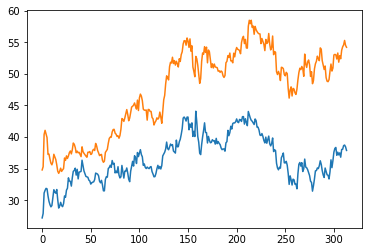

In [64]:
trade.groupby('tic')['close'].plot()

,002142,600036
2020-07-01,27.19,34.79
2020-07-02,27.89,35.30
2020-07-06,31.13,40.41
2020-07-07,31.56,41.06
2020-07-08,31.87,40.50
...,...,...
2021-10-22,38.06,54.29
2021-10-25,38.64,54.59
2021-10-26,38.73,55.30
2021-10-27,38.45,54.52


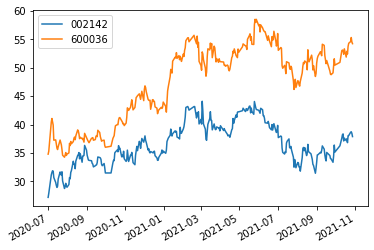

In [65]:
a=None
for i in trade.groupby('tic')['close']:
    if a is None:
        a=pd.DataFrame({i[0]:i[1]})
    else:
        a.loc[:,i[0]]=i[1]

a.index=pd.to_datetime(trade.date.unique())
a.plot()
a

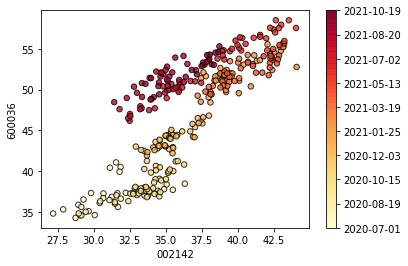

In [66]:
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the 
    changing relationship between the sets of prices    
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

draw_date_coloured_scatterplot(a.columns,a)

In [67]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    # model=trained_a2c, 
    environment = e_trade_gym)

going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
going short
hit end!


In [68]:
df_account_value.shape

(314, 2)

In [69]:
df_account_value

,date,account_value
0,2020-07-01,100000.00000
1,2020-07-02,99985.65065
2,2020-07-06,99744.25779
3,2020-07-07,99697.17466
4,2020-07-08,99738.26616
...,...,...
309,2021-10-22,51539.14966
310,2021-10-25,48865.65733
311,2021-10-26,44115.38638
312,2021-10-27,49574.07016


In [70]:
df_actions

,002142,600036
date,,
2020-07-01,-4,-21
2020-07-02,-4,-21
2020-07-06,-4,-21
2020-07-07,-4,-21
2020-07-08,-4,-21
...,...,...
2021-10-21,-4,-21
2021-10-22,-4,-21
2021-10-25,-4,-21


In [71]:
df_actions.sum()

002142   -1252
600036   -6573
dtype: int64

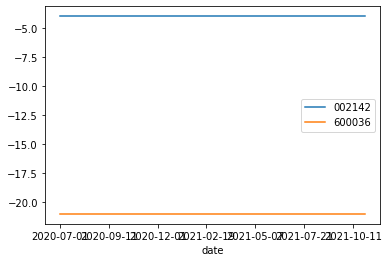

In [72]:
df_actions.plot()

In [73]:
agent.env.get_attr('actions_memory')

[[array([  3, -88]),
  array([-72, -70]),
  array([-87,  30]),
  array([ 75, -71]),
  array([-5,  1]),
  array([  55, -100]),
  array([100, -86]),
  array([-100, -100]),
  array([100, -26]),
  array([-100,  -20]),
  array([  80, -100]),
  array([  41, -100])]]

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [74]:
# assert 0

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [75]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.405973
Cumulative returns    -0.477417
Annual volatility      1.163520
Sharpe ratio           0.132408
Calmar ratio          -0.602948
Stability              0.334894
Max drawdown          -0.673313
Omega ratio            1.026550
Sortino ratio          0.194577
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.146110
Daily value at risk   -0.145978
dtype: float64


In [76]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [77]:
df_account_value.loc[0,'date']

'2020-07-01'

In [78]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

penalty of buying
==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,14
,Backtest
Annual return,-40.597%
Cumulative returns,-47.742%
Annual volatility,116.352%
Sharpe ratio,0.13
Calmar ratio,-0.60
Stability,0.33
Max drawdown,-67.331%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,67.33,2020-09-30,2021-05-26,2021-07-27,215
1,58.17,2021-07-27,2021-10-26,NaT,NaN
2,3.81,2020-07-27,2020-09-18,2020-09-30,48
3,0.52,2020-07-16,2020-07-20,2020-07-24,7
4,0.30,2020-07-01,2020-07-07,2020-07-10,8


Stress Events,mean,min,max
New Normal,0.06%,-31.91%,35.25%


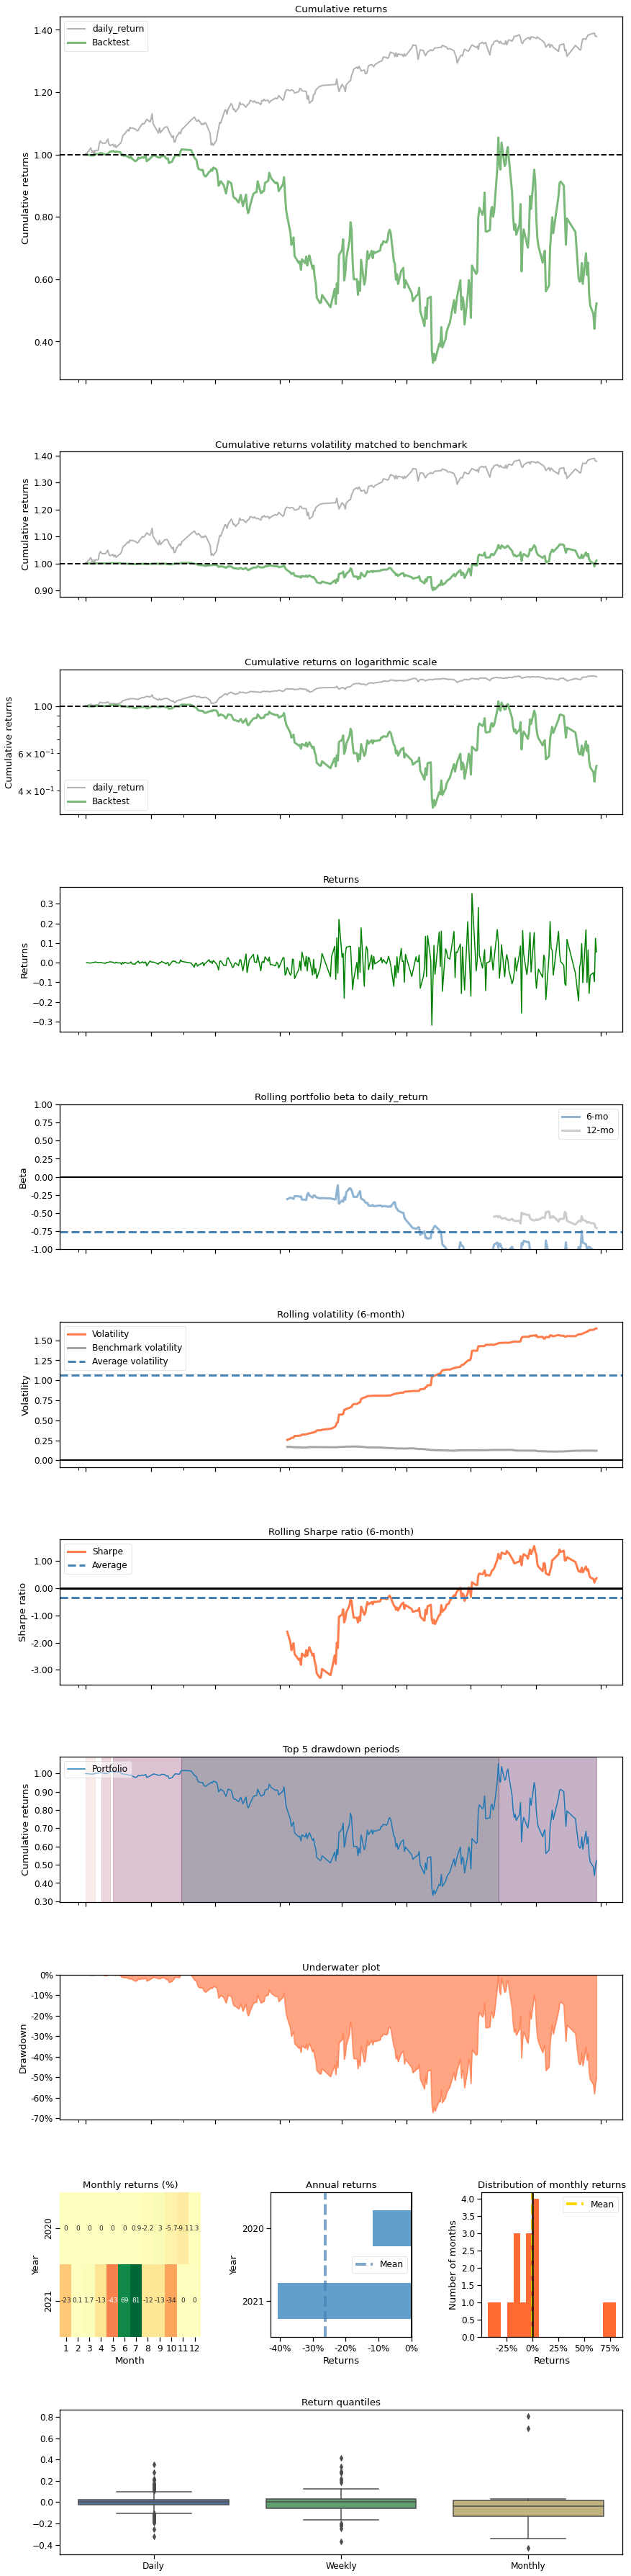

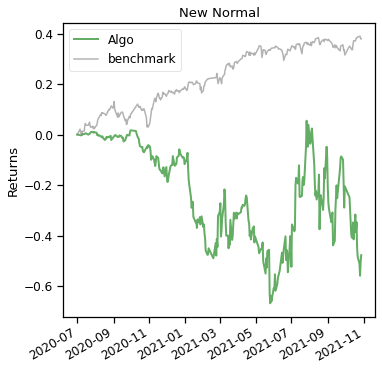

In [79]:
print("penalty of buying")
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,14
,Backtest
Annual return,-40.597%
Cumulative returns,-47.742%
Annual volatility,116.352%
Sharpe ratio,0.13
Calmar ratio,-0.60
Stability,0.33
Max drawdown,-67.331%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,67.33,2020-09-30,2021-05-26,2021-07-27,215
1,58.17,2021-07-27,2021-10-26,NaT,NaN
2,3.81,2020-07-27,2020-09-18,2020-09-30,48
3,0.52,2020-07-16,2020-07-20,2020-07-24,7
4,0.30,2020-07-01,2020-07-07,2020-07-10,8


Stress Events,mean,min,max
New Normal,0.06%,-31.91%,35.25%


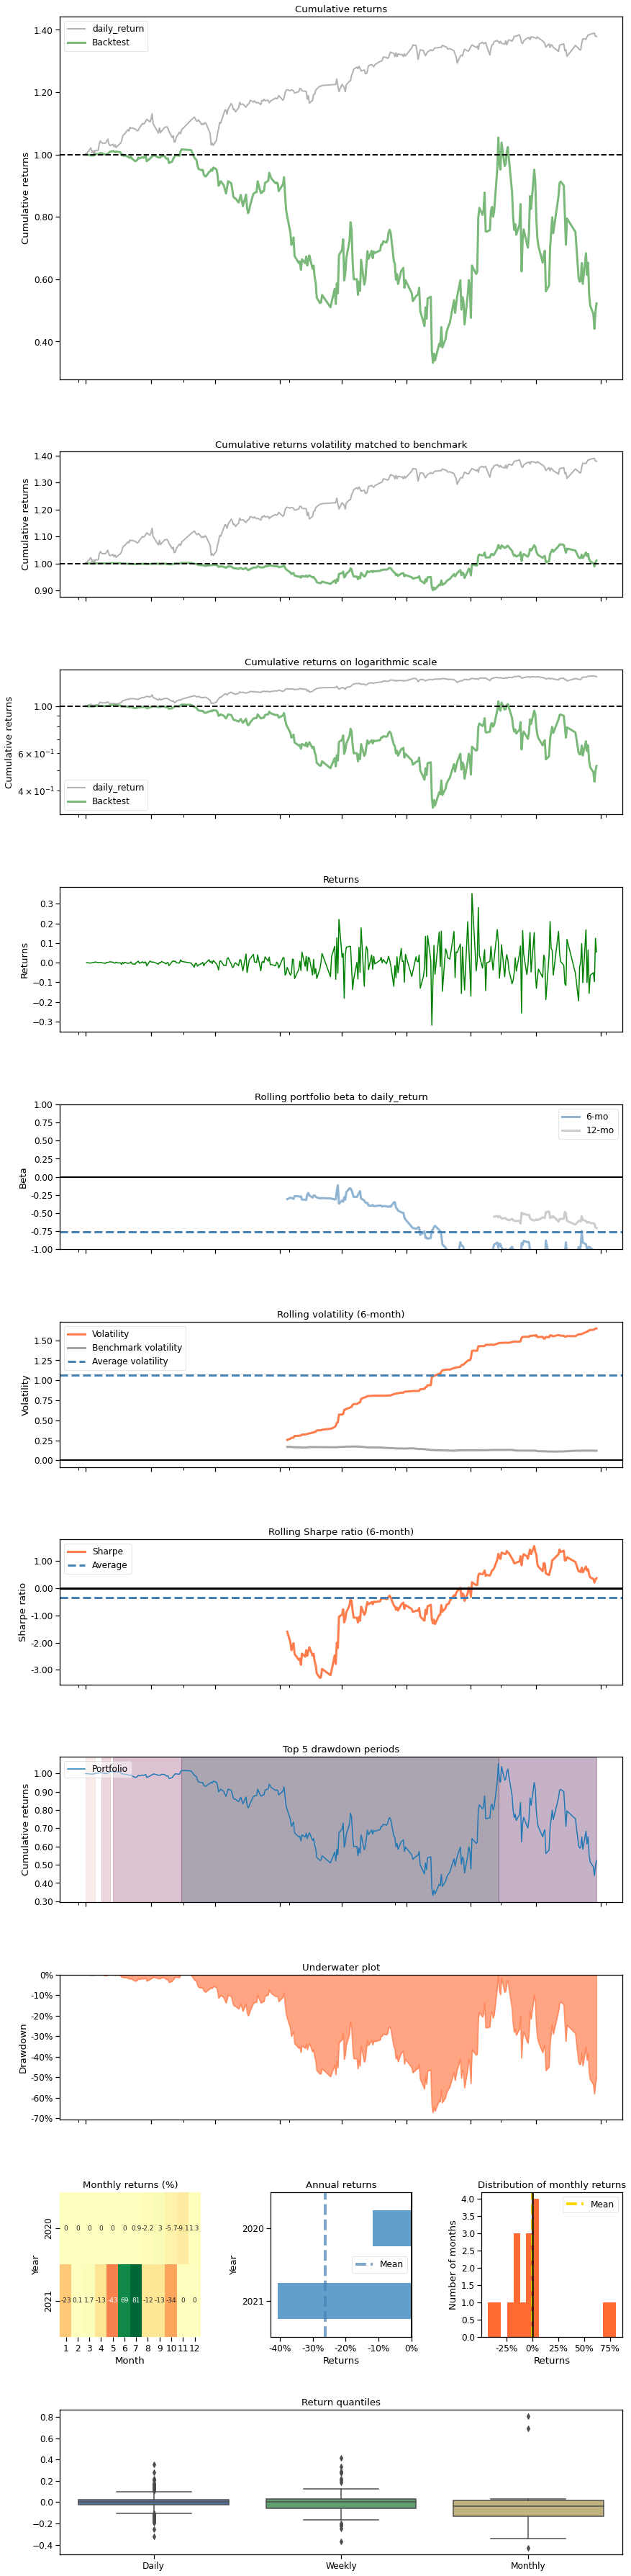

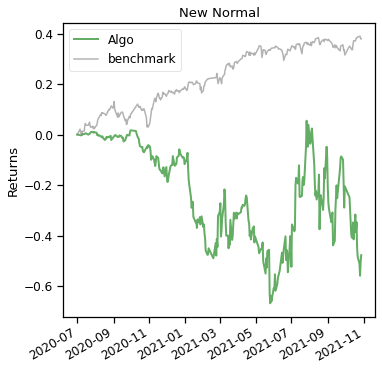

In [80]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [81]:
df_actions

,002142,600036
date,,
2020-07-01,-4,-21
2020-07-02,-4,-21
2020-07-06,-4,-21
2020-07-07,-4,-21
2020-07-08,-4,-21
...,...,...
2021-10-21,-4,-21
2021-10-22,-4,-21
2021-10-25,-4,-21


没有exposure penalty：
```text
[[array([ 0,  0, 10, 91,  0]),
  array([  0,   0, -10,  96, 100]),
  array([ 20, 100, 100, -13, -24]),
  array([100, 100, -95, 100, -76]),
  array([-31, -85,  40,  -9,  64]),
  array([  54,  100,   60, -100,  -43]),
  array([-31, 100,   0, 100, -21]),
  array([-71, -86,  77,  25,   0]),
  array([100,   2, -29, -85,   0]),
  array([-48,  37,  25,  16,  58]),
  array([  28,    7, -100,  -31,   -4]),
  array([-29, 100,  60,  34,  61]),
  array([ 86, 100, 100, -45,  74]),
  array([-100,  100,  -59,   15,  -92]),
  array([ -78,  100, -100,   60,  100]),
  array([   0,  -47,  100, -100,  -73]),
  array([   0, -100, -100,    4,  -41]),
  array([100, -10, 100,  42, -26]),
  array([  74, -100, -100,   37,  -57]),
  array([ -51,  100,  100, -100,    0]),
  array([ 21, -21, -15, 100,  80]),
  array([ 100,  -62, -100,   76,   59]),
  array([  40, -100,   47, -100,  -15]),
  array([-21, -57, -21, 100, 100]),
  array([ 100, -100,   21, -100,   51]),
  array([ 74,  67, 100,  98, -55]),
  array([ -31,   64,   -4,  100, -100]),
  array([-71, 100, 100, -74, -75]),
  array([-100,  -99,   66,   17,  -45]),
  array([-37,  62,  42, 100,   0]),
  array([ 61, -20,   4,  42,   0]),
  array([-58, 100,  67, -30,   0]),
  array([  38,  -25,   -4, -100,  100]),
  array([ 37,  30,  42, -68,  72]),
  array([ 43, 100, -15,  28,  81]),
  array([  14, -100,  -38, -100,  100]),
  array([ 100,   75, -100,   -3, -100]),
  array([  31,  -87,  -48, -100,  100]),
  array([  -4,  -57,   16,  -91, -100]),
  array([ 67, 100, -96, -32, -13]),
  array([  -9,   78, -100,    0,  -34]),
  array([ -60,   54, -100,   31,   65]),
  array([  44, -100,  -40,  100,  100]),
  array([96, -1, -3,  8, 69]),
  array([100, -90,   0,  10,  24]),
  array([-100,  -76,    0, -100,   39]),
  array([ -35, -100,   74,   -7,   68]),
  array([-57, 100,  25,  76, 100]),
  array([ -94, -100,  -21, -100,   96]),
  array([-29, -48, -29, -15, 100]),
  array([ 100, -100,   60,   -3,  -38]),
  array([ -83, -100, -100,    0,   51]),
  array([-64,  -5,  48,   0, -23]),
  array([  84,    0,    0,   80, -100]),
  array([-50,   0,  -5,  19, -35]),
  array([ 76,  43, -40,  58, -84]),
  array([  14,  -43,   11, -100, -100]),
  array([-42,   0,  20, -20,   0]),
  array([-64,   0, -43, -37,  37]),
  array([ -92,    0,   20,   45, -100]),
  array([ 43, 100,  17,  35, -50]),
  array([-89,  47, -37,  19,  65]),
  array([-100,  100,    5,  -66, -100]),
  array([-29,  39,  -5, -33,  22]),
  array([ -48, -100,   94,    0,  -90]),
  array([100,  19, 100,  32,  17]),
  array([-72, 100,  -5,  59, 100]),
  array([100, 100, -67, -83,  35]),
  array([100,  86,  -1,  -8,  48]),
  array([-82,  45, 100, 100, -37]),
  array([ 100, -100,  -21, -100,    0]),
  array([ 100,  -84,  100,    0, -100]),
  array([  90, -100,  -47,  100,   13]),
  array([ 100,   76, -100,  100,   26]),
  array([ 66,  31, -25, 100, -16]),
  array([ -71,  100,   45, -100,  100]),
  array([-100,  -25,  100,  100, -100]),
  array([  31, -100,    6, -100, -100]),
  array([  9,  21, -14, -17, -69]),
  array([ 13,  -5,  69,  21, -68]),
  array([ 83, -13,  70, -45, 100]),
  array([  82,  -98,  100, -100,  -46]),
  array([-50,  45, 100, -56, -97]),
  array([100,  -1,  74, 100, -16]),
  array([-100,   13,   29,   31,  100]),
  array([ 34, 100,  14, 100,  14]),
  array([  79, -100,   98,  -45,   20]),
  array([-100,  -27,  100,  100,  100]),
  array([ -28,  100,   86, -100,  -39]),
  array([-100,  -38,  -93,  100,   21]),
  array([ -99,  -93, -100,   43,  -26]),
  array([ 65, 100, 100, 100, -64]),
  array([ 100,  -65,  -97,  100, -100]),
  array([ 33,  -9, -52, 100, 100]),
  array([  47,   25,   10, -100,  -76]),
  array([-80,  36, 100,   7, -55]),
  array([ 22, -50, 100, -78, 100]),
  array([-33,  -1, 100, -53, -48]),
  array([   5,   63,  -35,  -35, -100]),
  array([  9,  -2, 100,  31,   6]),
  array([ -54,   56, -100,   71,   16]),
  array([ 76,  89,  77, 100, -81]),
  array([87, -1, 68, 17, 16]),
  array([  -6, -100,   73, -100,  100]),
  array([ 100, -100, -100,  -95,  -85]),
  array([  40,  100,   15, -100,  -31]),
  array([100,  49,  69, -94,   0]),
  array([  17, -100,  100,   63,  100]),
  array([ 80, -19, 100, -93, 100]),
  array([-98, -60,  12, -88, -47]),
  array([  44, -100,  -97,  100,  100]),
  array([-100,  -38,   81,  -81,  -29]),
  array([100,  37, 100,   6,  22]),
  array([ -67,  -60, -100,   30,  100]),
  array([ 100,   47, -100,  -93,  -13]),
  array([-58,  28, -25,  86,   0]),
  array([ -1,  61, -84,  40,  12]),
  array([ -46,  100,  -96, -100,  100]),
  array([ 100, -100, -100,   43,   27]),
  array([ -85,   72,  100, -100,   -3]),
  array([  54, -100, -100,  -16,  100]),
  array([ 43, -42,  34,   0, -77]),
  array([ -3, 100, 100,  66,  31]),
  array([  4, -64, -23,  45, -28]),
  array([-100, -100,  -43,  100, -100]),
  array([  28,  -52, -100, -100,   96]),
  array([ -35,  100,  -20,  -71, -100]),
  array([-100,   52,  -99,  100,   45]),
  array([-100,  -90,   82, -100,  100]),
  array([ 94,  86, -30, 100,   0]),
  array([ 44, 100, -42,  21, -80]),
  array([ 100, -100,  100,  -56,   11]),
  array([ 100,  100,  -57,   38, -100]),
  array([-100,  -83, -100,   11,  100]),
  array([-10,  95, -50, -53,  -9]),
  array([-100,    4,    0,  -81,  -53]),
  array([   7,  -66,   87,  100, -100]),
  array([ 100,  100,   21, -100,   31]),
  array([ -45, -100,  100,  -20,   31]),
  array([ 100,  -38, -100,    0,  -95]),
  array([ -6, -26, 100,   0, -21]),
  array([ 100, -100,   57,   56, -100]),
  array([-11, -67, -11,  89,  37]),
  array([-74,  -5, -17, -61, 100]),
  array([ 18,   0, -54, -68,   8]),
  array([100,   0, -40, -16,  58]),
  array([-100,    0,   84,  100, -100]),
  array([  89,    4, -100,   90,  -78]),
  array([  55,   -4, -100,  -29,  100]),
  array([ 50,  70, 100,  18, 100]),
  array([   1,   42,   70, -100,  100]),
  array([ -68,   -1, -100,  -79,    4]),
  array([-100,  -54,  100,  100,  -51]),
  array([-31,   7,  67,  59,  49]),
  array([   5,   42, -100,  -20,  100]),
  array([ 100,   63, -100,   70,   32]),
  array([-35,  39,  55,  -3,  36]),
  array([ 18,  56, 100, -40, 100]),
  array([100,  88, -27, -63, -33])]]
  ```

In [82]:
agent.env.get_attr('actions_memory')

[[array([  3, -88]),
  array([-72, -70]),
  array([-87,  30]),
  array([ 75, -71]),
  array([-5,  1]),
  array([  55, -100]),
  array([100, -86]),
  array([-100, -100]),
  array([100, -26]),
  array([-100,  -20]),
  array([  80, -100]),
  array([  41, -100])]]

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [1]:
root='/content/drive/MyDrive/HYF/Graduation_Fin/FinRL'
%cd /content/drive/MyDrive/HYF/Graduation_Fin/FinRL
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists(root+"/" + config.DATA_SAVE_DIR):
    os.makedirs(root+"/" + config.DATA_SAVE_DIR)
if not os.path.exists(root+"/" + config.TRAINED_MODEL_DIR):
    os.makedirs(root+"/" + config.TRAINED_MODEL_DIR)
if not os.path.exists(root+"/" + config.TENSORBOARD_LOG_DIR):
    os.makedirs(root+"/" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists(root+"/" + config.RESULTS_DIR):
    os.makedirs(root+"/" + config.RESULTS_DIR)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
# from finrl.finrl_meta.preprocessor.processor_joinquant import JoinQuantEngineer
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_pairs_trading import PairsTradingEnv

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools
# import jqdatasdk
# jqdatasdk.auth('15857500957','Qazwsxedcrfv0957')

/content/drive/MyDrive/HYF/Graduation_Fin/FinRL


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
processed_full=pd.read_csv('./datasets/train/processed_full.csv',index_col=0,header=0,dtype={"tic":str})
# 只选择两个股票
processed_full=processed_full[np.logical_or(processed_full['tic']=='600036',processed_full['tic']=='002142')]
processed_full

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2019-10-09,002142,26.28,27.54,26.94,25.95,377299.44,0.67,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,26.940000,26.940000,18.639999
1,2019-10-09,600036,34.52,35.67,35.18,34.50,821613.75,0.40,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,35.180000,35.180000,18.639999
2,2019-10-10,002142,26.83,27.22,26.95,26.47,223220.73,0.40,3.0,0.000224,26.959142,26.930858,100.000000,66.666667,100.000000,26.945000,26.945000,17.570000
3,2019-10-10,600036,35.21,35.38,35.11,35.02,378700.53,0.18,3.0,-0.001571,35.243995,35.046005,0.000000,66.666667,100.000000,35.145000,35.145000,17.570000
4,2019-10-11,002142,26.96,27.61,27.53,26.70,219037.48,0.39,4.0,0.018272,27.815574,26.464426,100.000000,100.000000,100.000000,27.140000,27.140000,15.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,2021-10-26,600036,54.59,56.23,55.30,54.30,715423.69,0.35,1.0,0.905397,55.907193,48.025807,56.819333,161.034620,27.304537,52.044667,50.821833,15.980000
1498,2021-10-27,002142,38.58,38.87,38.45,37.97,149993.34,0.25,2.0,0.935435,40.209902,33.377098,55.536024,101.200771,23.170640,36.175000,35.070500,16.980000
1499,2021-10-27,600036,55.20,55.20,54.52,53.83,420394.41,0.20,2.0,0.933634,56.127249,48.316751,55.130135,114.567688,21.459275,52.155333,50.935500,16.980000
1500,2021-10-28,002142,38.18,38.70,37.88,37.36,220415.56,0.37,3.0,0.879953,40.171473,33.801527,53.985588,75.318661,12.762654,36.267667,35.160167,16.530001


In [3]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

344
628


In [4]:
train

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2019-10-09,002142,26.28,27.54,26.94,25.95,377299.44,0.67,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,26.940000,26.940000,18.639999
0,2019-10-09,600036,34.52,35.67,35.18,34.50,821613.75,0.40,2.0,0.000000,26.959142,26.930858,100.000000,66.666667,100.000000,35.180000,35.180000,18.639999
1,2019-10-10,002142,26.83,27.22,26.95,26.47,223220.73,0.40,3.0,0.000224,26.959142,26.930858,100.000000,66.666667,100.000000,26.945000,26.945000,17.570000
1,2019-10-10,600036,35.21,35.38,35.11,35.02,378700.53,0.18,3.0,-0.001571,35.243995,35.046005,0.000000,66.666667,100.000000,35.145000,35.145000,17.570000
2,2019-10-11,002142,26.96,27.61,27.53,26.70,219037.48,0.39,4.0,0.018272,27.815574,26.464426,100.000000,100.000000,100.000000,27.140000,27.140000,15.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2020-06-26,600036,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
170,2020-06-29,002142,26.22,26.52,26.39,25.85,307973.41,0.55,0.0,0.083559,27.726467,25.004533,53.675052,25.790950,16.527066,26.016000,25.046333,31.780001
170,2020-06-29,600036,34.17,34.30,33.64,33.49,567297.50,0.28,0.0,-0.147290,35.943614,32.941386,47.846759,-53.038389,0.688877,34.266000,33.729833,31.780001
171,2020-06-30,002142,26.48,26.70,26.27,26.16,282245.44,0.50,1.0,0.097145,27.706873,24.992127,53.036881,34.736262,19.670510,26.065000,25.099833,30.430000


In [5]:

train.pivot_table(index=['date'],columns=['tic'],values=['close']).iloc[:,0][0]

26.94

In [6]:
trade.head()

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2020-07-01,002142,26.27,27.28,27.19,26.21,418918.59,0.75,2.0,0.180073,27.775980,24.973020,57.083722,85.002786,28.893817,26.131000,25.173000,28.620001
0,2020-07-01,600036,33.79,34.80,34.79,33.61,799096.44,0.39,2.0,-0.077263,35.944940,32.927060,52.960133,10.803952,13.406182,34.294667,33.789500,28.620001
1,2020-07-02,002142,27.15,28.05,27.89,26.75,577619.00,1.03,3.0,0.298832,27.915443,24.896557,59.809650,143.134805,38.856738,26.211000,25.258667,27.680000
1,2020-07-02,600036,34.65,35.47,35.30,34.30,1245178.00,0.60,3.0,0.026686,35.984104,32.913896,54.989425,73.899649,22.639615,34.329000,33.842333,27.680000
2,2020-07-06,002142,28.71,31.13,31.13,28.71,765799.62,1.36,0.0,0.737990,29.311641,23.974359,69.397261,308.013870,62.475503,26.485333,25.488333,27.940001


In [7]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [8]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 2, State Space: 21


In [9]:
env_kwargs = { 
        "hmax": 1e4, 
        "initial_amount": 0, # 十万空余资金
        "num_stock_shares": [0] * stock_dimension, # 每个股票十手
        "buy_cost_pct": [0.000675] * stock_dimension, 
        "sell_cost_pct": [0.001] * stock_dimension, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.INDICATORS, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4,
        # "model_name":"pair_trading",
        # "mode":"test",
        # "":,
        
        
         }
e_train_gym = PairsTradingEnv(df = train, **env_kwargs)

In [10]:
np.array([1,2]).tolist().append(3)

## Environment for Training



In [11]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 3: PPO

In [12]:
agent = DRLAgent(env = env_train)

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [13]:
trained_ppo = agent.train_model(model=model_ppo, 
                    tb_log_name='ppo',
                    total_timesteps=20000)

/content/drive/MyDrive/HYF/Graduation_Fin/FinRL/finrl/finrl_meta/env_stock_trading/env_pairs_trading.py:387: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions=(np.array(actions)//self.shares_per_hand) *self.shares_per_hand


<class 'numpy.ndarray'> [-699  800]
<class 'numpy.ndarray'> [-9399 12100]
<class 'numpy.ndarray'> [-9999 13100]
selling hits the limit -10000 -9999
<class 'numpy.ndarray'> [ 10000 -13499]
<class 'numpy.ndarray'> [-6899  9200]
selling hits the limit -10000 -7399
selling hits the limit -10000 -2199
selling hits the limit -10000 -999
selling hits the limit -10000 -3299
selling hits the limit -10000 -1399
selling hits the limit -10000 -1899
selling hits the limit -10000.0 -2099
selling hits the limit -10000.0 -3099
selling hits the limit -10000 -9999
selling hits the limit -10000 -9999
selling hits the limit -10000 -9999
selling hits the limit -10000 -9999
selling hits the limit -10000 -6299
selling hits the limit -10000.0 -13399
selling hits the limit -10000.0 -13499
selling hits the limit -10000.0 -1299
selling hits the limit -10000 -8699
selling hits the limit -10000.0 -13499
selling hits the limit -10000.0 -5099
selling hits the limit -10000.0 -13599
selling hits the limit -10000.0 -31

/content/drive/MyDrive/HYF/Graduation_Fin/FinRL/finrl/finrl_meta/env_stock_trading/env_pairs_trading.py:213: RuntimeWarning: divide by zero encountered in double_scalars
  available_amount = self.state[0] / (self.state[index + 1]*(1 + self.buy_cost_pct[index])) # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0


Streaming output truncated to the last 5000 lines.
selling hits the limit -10000.0 -5699
selling hits the limit -10000.0 -10199
selling hits the limit -10000.0 -10199
selling hits the limit -10000.0 -10099
selling hits the limit -10000.0 -4299
selling hits the limit -10000.0 -2099
selling hits the limit -10000.0 -9899
selling hits the limit -10000.0 -6499
selling hits the limit -10000.0 -4499
selling hits the limit -10000.0 -9999
selling hits the limit -10000.0 -9999
<class 'numpy.ndarray'> [-4999  4800]
<class 'numpy.ndarray'> [-7599  7400]
<class 'numpy.ndarray'> [ 6100 -6299]
<class 'numpy.ndarray'> [-2899  2900]
<class 'numpy.ndarray'> [-9999 10400]
selling hits the limit -10000 -3699
selling hits the limit -10000 -9999
selling hits the limit -10000 -7599
selling hits the limit -10000 -2699
selling hits the limit -10000.0 -7699
selling hits the limit -10000.0 -10199
selling hits the limit -10000.0 -9999
selling hits the limit -10000.0 -9999
selling hits the limit -10000.0 -9999
sel

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [14]:
# data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
# insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])
# insample_risk_indicator.vix.describe()
# insample_risk_indicator.vix.quantile(0.996)
# insample_risk_indicator.turbulence.describe()
# insample_risk_indicator.turbulence.quantile(0.996)

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [15]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
# from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv

e_trade_gym = PairsTradingEnv(df = trade, turbulence_threshold = None,risk_indicator_col='vix', **env_kwargs)
# e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [16]:
trade.head()

,date,tic,open,high,close,low,volume,turnover,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
0,2020-07-01,002142,26.27,27.28,27.19,26.21,418918.59,0.75,2.0,0.180073,27.775980,24.973020,57.083722,85.002786,28.893817,26.131000,25.173000,28.620001
0,2020-07-01,600036,33.79,34.80,34.79,33.61,799096.44,0.39,2.0,-0.077263,35.944940,32.927060,52.960133,10.803952,13.406182,34.294667,33.789500,28.620001
1,2020-07-02,002142,27.15,28.05,27.89,26.75,577619.00,1.03,3.0,0.298832,27.915443,24.896557,59.809650,143.134805,38.856738,26.211000,25.258667,27.680000
1,2020-07-02,600036,34.65,35.47,35.30,34.30,1245178.00,0.60,3.0,0.026686,35.984104,32.913896,54.989425,73.899649,22.639615,34.329000,33.842333,27.680000
2,2020-07-06,002142,28.71,31.13,31.13,28.71,765799.62,1.36,0.0,0.737990,29.311641,23.974359,69.397261,308.013870,62.475503,26.485333,25.488333,27.940001


tic
002142    AxesSubplot(0.125,0.125;0.775x0.755)
600036    AxesSubplot(0.125,0.125;0.775x0.755)
Name: close, dtype: object

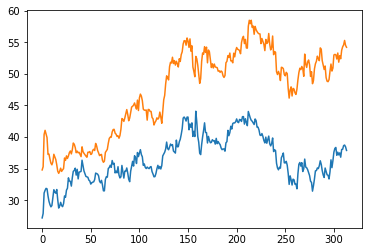

In [17]:
trade.groupby('tic')['close'].plot()

,002142,600036
2020-07-01,27.19,34.79
2020-07-02,27.89,35.30
2020-07-06,31.13,40.41
2020-07-07,31.56,41.06
2020-07-08,31.87,40.50
...,...,...
2021-10-22,38.06,54.29
2021-10-25,38.64,54.59
2021-10-26,38.73,55.30
2021-10-27,38.45,54.52


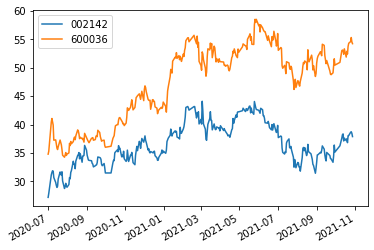

In [18]:
a=None
for i in trade.groupby('tic')['close']:
    if a is None:
        a=pd.DataFrame({i[0]:i[1]})
    else:
        a.loc[:,i[0]]=i[1]

a.index=pd.to_datetime(trade.date.unique())
a.plot()
a

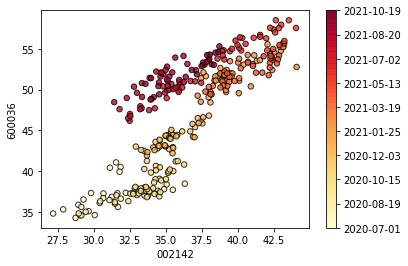

In [19]:
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the 
    changing relationship between the sets of prices    
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

draw_date_coloured_scatterplot(a.columns,a)

In [20]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    # model=trained_a2c, 
    environment = e_trade_gym)

/content/drive/MyDrive/HYF/Graduation_Fin/FinRL/finrl/finrl_meta/env_stock_trading/env_pairs_trading.py:387: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions=(np.array(actions)//self.shares_per_hand) *self.shares_per_hand


<class 'numpy.ndarray'> [-1999  2300]
<class 'numpy.ndarray'> [-6499  8000]
<class 'numpy.ndarray'> [-6499  8300]
<class 'numpy.ndarray'> [-6499  8300]
selling hits the limit -10000 -6499
<class 'numpy.ndarray'> [-6499  8100]
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the limit -10000 -6499
selling hits the l

In [21]:
df_account_value.shape

(314, 2)

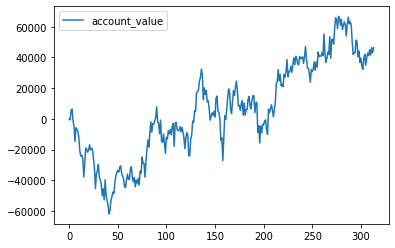

In [22]:
df_account_value.plot()

In [23]:
df_actions

,002142,600036
date,,
2020-07-01,-1999,1559
2020-07-02,-6499,5126
2020-07-06,-1502,1155
2020-07-07,0,0
2020-07-08,0,0
...,...,...
2021-10-21,0,0
2021-10-22,0,0
2021-10-25,0,0


In [37]:
shares_per_hand=100
actions=np.array([0.536867])
hmax=1e4
actions = actions * hmax  # actions initially is scaled between 0 to 1
temp=np.array(actions).tolist()
temp.append(-0.2345*actions)
actions=temp
actions=(np.array(actions)//shares_per_hand) *shares_per_hand
actions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


array([5300.0, array([-1300.])], dtype=object)

In [24]:
df_actions.sum()

002142   -10000
600036     7840
dtype: int64

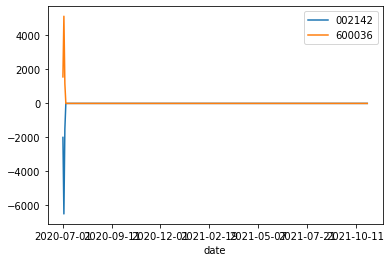

In [25]:
df_actions.plot()

In [26]:
agent.env.get_attr('actions_memory')

[[array([ 3400, -3399]),
  array([ 7400, -6601]),
  array([0, 0]),
  array([0, 0]),
  array([0, 0]),
  array([-3699,  3700]),
  array([-4799,  4035]),
  array([10000, -7735]),
  array([-9999,  7869]),
  array([10000, -7869]),
  array([0, 0]),
  array([0, 0])]]

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [27]:
# assert 0

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [28]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return              inf
Cumulative returns         inf
Annual volatility          NaN
Sharpe ratio               NaN
Calmar ratio               NaN
Stability                  NaN
Max drawdown              -inf
Omega ratio            0.00000
Sortino ratio              NaN
Skew                       NaN
Kurtosis                   NaN
Tail ratio             1.98346
Daily value at risk        NaN
dtype: float64


/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in true_divide
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:589: RuntimeWarning: invalid value encountered in double_scalars
  ) / abs(max_dd)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [29]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [30]:
df_account_value.loc[0,'date']

'2020-07-01'

In [31]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

penalty of buying
==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:396: RuntimeWarning: invalid value encountered in true_divide
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:589: RuntimeWarning: invalid value encountered in double_scalars
  ) / abs(max_dd)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Start date,2020-07-01
End date,2021-10-28
Total months,14
,Backtest
Annual return,inf%
Cumulative returns,inf%
Annual volatility,nan%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,NaN
Max drawdown,-inf%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,inf,2020-07-01,2020-07-02,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1025: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1026: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


ValueError: ignored

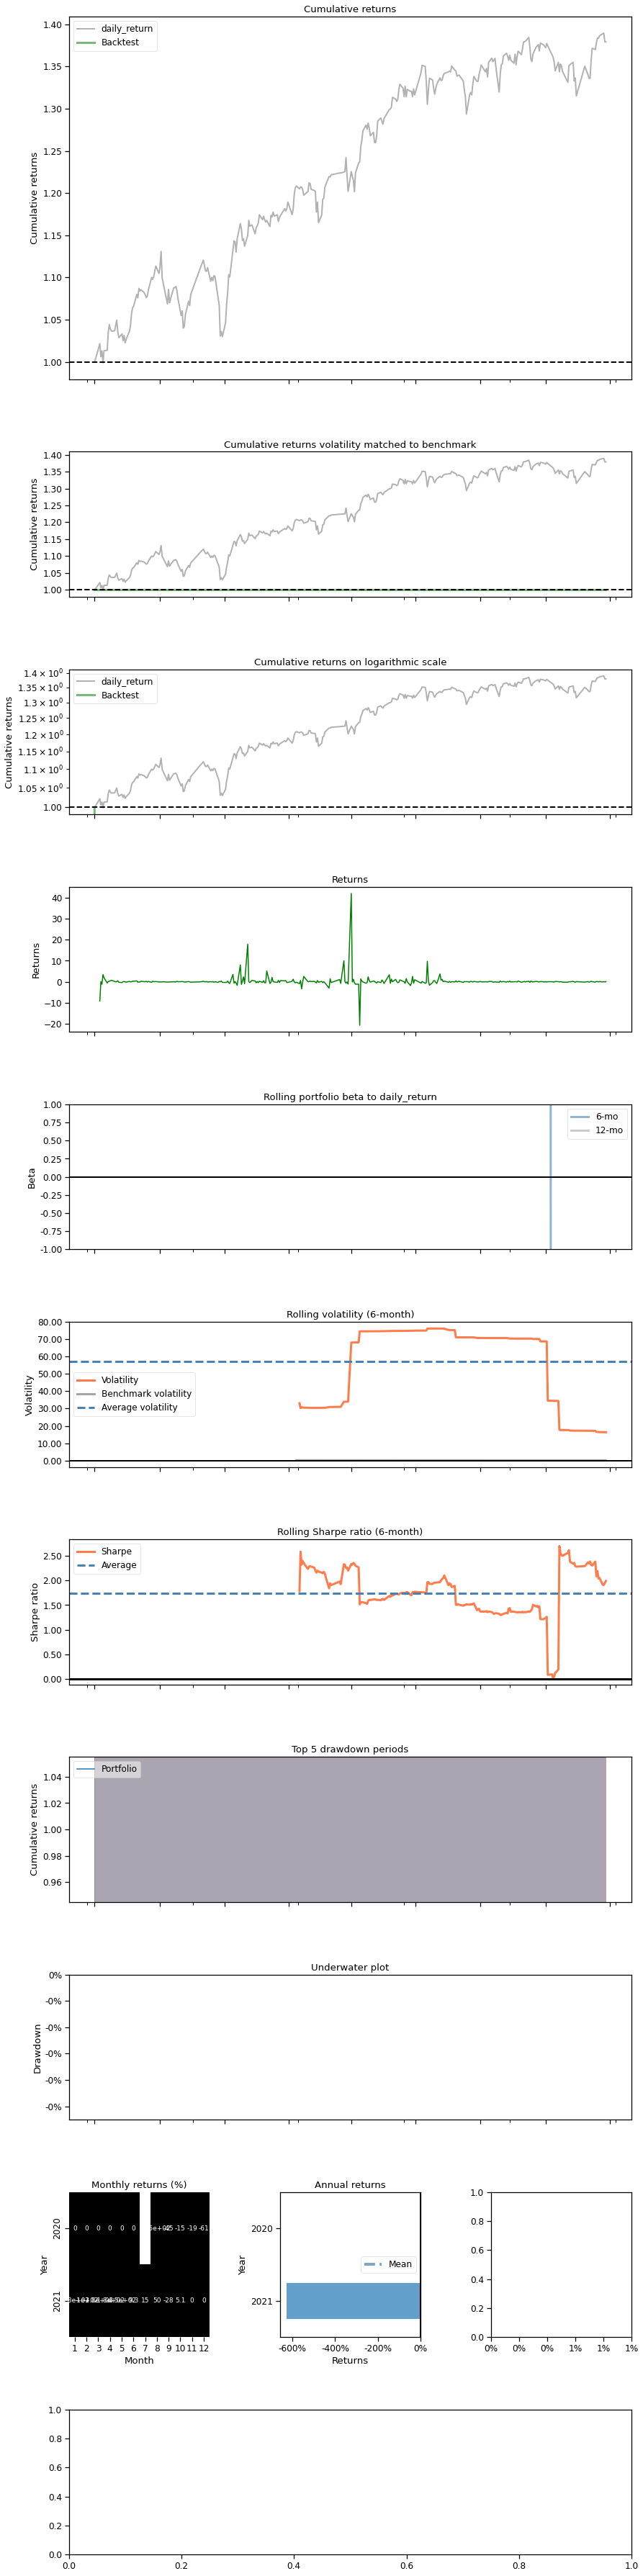

In [32]:
print("penalty of buying")
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [ ]:
df_actions

没有exposure penalty：
```text
[[array([ 0,  0, 10, 91,  0]),
  array([  0,   0, -10,  96, 100]),
  array([ 20, 100, 100, -13, -24]),
  array([100, 100, -95, 100, -76]),
  array([-31, -85,  40,  -9,  64]),
  array([  54,  100,   60, -100,  -43]),
  array([-31, 100,   0, 100, -21]),
  array([-71, -86,  77,  25,   0]),
  array([100,   2, -29, -85,   0]),
  array([-48,  37,  25,  16,  58]),
  array([  28,    7, -100,  -31,   -4]),
  array([-29, 100,  60,  34,  61]),
  array([ 86, 100, 100, -45,  74]),
  array([-100,  100,  -59,   15,  -92]),
  array([ -78,  100, -100,   60,  100]),
  array([   0,  -47,  100, -100,  -73]),
  array([   0, -100, -100,    4,  -41]),
  array([100, -10, 100,  42, -26]),
  array([  74, -100, -100,   37,  -57]),
  array([ -51,  100,  100, -100,    0]),
  array([ 21, -21, -15, 100,  80]),
  array([ 100,  -62, -100,   76,   59]),
  array([  40, -100,   47, -100,  -15]),
  array([-21, -57, -21, 100, 100]),
  array([ 100, -100,   21, -100,   51]),
  array([ 74,  67, 100,  98, -55]),
  array([ -31,   64,   -4,  100, -100]),
  array([-71, 100, 100, -74, -75]),
  array([-100,  -99,   66,   17,  -45]),
  array([-37,  62,  42, 100,   0]),
  array([ 61, -20,   4,  42,   0]),
  array([-58, 100,  67, -30,   0]),
  array([  38,  -25,   -4, -100,  100]),
  array([ 37,  30,  42, -68,  72]),
  array([ 43, 100, -15,  28,  81]),
  array([  14, -100,  -38, -100,  100]),
  array([ 100,   75, -100,   -3, -100]),
  array([  31,  -87,  -48, -100,  100]),
  array([  -4,  -57,   16,  -91, -100]),
  array([ 67, 100, -96, -32, -13]),
  array([  -9,   78, -100,    0,  -34]),
  array([ -60,   54, -100,   31,   65]),
  array([  44, -100,  -40,  100,  100]),
  array([96, -1, -3,  8, 69]),
  array([100, -90,   0,  10,  24]),
  array([-100,  -76,    0, -100,   39]),
  array([ -35, -100,   74,   -7,   68]),
  array([-57, 100,  25,  76, 100]),
  array([ -94, -100,  -21, -100,   96]),
  array([-29, -48, -29, -15, 100]),
  array([ 100, -100,   60,   -3,  -38]),
  array([ -83, -100, -100,    0,   51]),
  array([-64,  -5,  48,   0, -23]),
  array([  84,    0,    0,   80, -100]),
  array([-50,   0,  -5,  19, -35]),
  array([ 76,  43, -40,  58, -84]),
  array([  14,  -43,   11, -100, -100]),
  array([-42,   0,  20, -20,   0]),
  array([-64,   0, -43, -37,  37]),
  array([ -92,    0,   20,   45, -100]),
  array([ 43, 100,  17,  35, -50]),
  array([-89,  47, -37,  19,  65]),
  array([-100,  100,    5,  -66, -100]),
  array([-29,  39,  -5, -33,  22]),
  array([ -48, -100,   94,    0,  -90]),
  array([100,  19, 100,  32,  17]),
  array([-72, 100,  -5,  59, 100]),
  array([100, 100, -67, -83,  35]),
  array([100,  86,  -1,  -8,  48]),
  array([-82,  45, 100, 100, -37]),
  array([ 100, -100,  -21, -100,    0]),
  array([ 100,  -84,  100,    0, -100]),
  array([  90, -100,  -47,  100,   13]),
  array([ 100,   76, -100,  100,   26]),
  array([ 66,  31, -25, 100, -16]),
  array([ -71,  100,   45, -100,  100]),
  array([-100,  -25,  100,  100, -100]),
  array([  31, -100,    6, -100, -100]),
  array([  9,  21, -14, -17, -69]),
  array([ 13,  -5,  69,  21, -68]),
  array([ 83, -13,  70, -45, 100]),
  array([  82,  -98,  100, -100,  -46]),
  array([-50,  45, 100, -56, -97]),
  array([100,  -1,  74, 100, -16]),
  array([-100,   13,   29,   31,  100]),
  array([ 34, 100,  14, 100,  14]),
  array([  79, -100,   98,  -45,   20]),
  array([-100,  -27,  100,  100,  100]),
  array([ -28,  100,   86, -100,  -39]),
  array([-100,  -38,  -93,  100,   21]),
  array([ -99,  -93, -100,   43,  -26]),
  array([ 65, 100, 100, 100, -64]),
  array([ 100,  -65,  -97,  100, -100]),
  array([ 33,  -9, -52, 100, 100]),
  array([  47,   25,   10, -100,  -76]),
  array([-80,  36, 100,   7, -55]),
  array([ 22, -50, 100, -78, 100]),
  array([-33,  -1, 100, -53, -48]),
  array([   5,   63,  -35,  -35, -100]),
  array([  9,  -2, 100,  31,   6]),
  array([ -54,   56, -100,   71,   16]),
  array([ 76,  89,  77, 100, -81]),
  array([87, -1, 68, 17, 16]),
  array([  -6, -100,   73, -100,  100]),
  array([ 100, -100, -100,  -95,  -85]),
  array([  40,  100,   15, -100,  -31]),
  array([100,  49,  69, -94,   0]),
  array([  17, -100,  100,   63,  100]),
  array([ 80, -19, 100, -93, 100]),
  array([-98, -60,  12, -88, -47]),
  array([  44, -100,  -97,  100,  100]),
  array([-100,  -38,   81,  -81,  -29]),
  array([100,  37, 100,   6,  22]),
  array([ -67,  -60, -100,   30,  100]),
  array([ 100,   47, -100,  -93,  -13]),
  array([-58,  28, -25,  86,   0]),
  array([ -1,  61, -84,  40,  12]),
  array([ -46,  100,  -96, -100,  100]),
  array([ 100, -100, -100,   43,   27]),
  array([ -85,   72,  100, -100,   -3]),
  array([  54, -100, -100,  -16,  100]),
  array([ 43, -42,  34,   0, -77]),
  array([ -3, 100, 100,  66,  31]),
  array([  4, -64, -23,  45, -28]),
  array([-100, -100,  -43,  100, -100]),
  array([  28,  -52, -100, -100,   96]),
  array([ -35,  100,  -20,  -71, -100]),
  array([-100,   52,  -99,  100,   45]),
  array([-100,  -90,   82, -100,  100]),
  array([ 94,  86, -30, 100,   0]),
  array([ 44, 100, -42,  21, -80]),
  array([ 100, -100,  100,  -56,   11]),
  array([ 100,  100,  -57,   38, -100]),
  array([-100,  -83, -100,   11,  100]),
  array([-10,  95, -50, -53,  -9]),
  array([-100,    4,    0,  -81,  -53]),
  array([   7,  -66,   87,  100, -100]),
  array([ 100,  100,   21, -100,   31]),
  array([ -45, -100,  100,  -20,   31]),
  array([ 100,  -38, -100,    0,  -95]),
  array([ -6, -26, 100,   0, -21]),
  array([ 100, -100,   57,   56, -100]),
  array([-11, -67, -11,  89,  37]),
  array([-74,  -5, -17, -61, 100]),
  array([ 18,   0, -54, -68,   8]),
  array([100,   0, -40, -16,  58]),
  array([-100,    0,   84,  100, -100]),
  array([  89,    4, -100,   90,  -78]),
  array([  55,   -4, -100,  -29,  100]),
  array([ 50,  70, 100,  18, 100]),
  array([   1,   42,   70, -100,  100]),
  array([ -68,   -1, -100,  -79,    4]),
  array([-100,  -54,  100,  100,  -51]),
  array([-31,   7,  67,  59,  49]),
  array([   5,   42, -100,  -20,  100]),
  array([ 100,   63, -100,   70,   32]),
  array([-35,  39,  55,  -3,  36]),
  array([ 18,  56, 100, -40, 100]),
  array([100,  88, -27, -63, -33])]]
  ```

In [ ]:
agent.env.get_attr('actions_memory')